## Imports

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV, validation_curve
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score

import matplotlib.pyplot as plt
from scipy.sparse import hstack
import itertools
import math
import re
from nltk.stem.porter import PorterStemmer

%matplotlib inline

/home/carol/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Functions

In [2]:
#bonus
porter_stemmer=PorterStemmer()
def stemming_tokenizer(str_input):
    words = re.sub(r"[^A-Za-z0-9\-]", " ", str_input).lower().split()
    words = [porter_stemmer.stem(word) for word in words]
    return words

In [3]:
#filters dataframe's columns according to their correlation with the passed predicate
def correlation_filter(dataframe, target, predicate):
    correlation_mat = np.array(dataframe.corr().abs())
    new_dataframe = None
    target_column_idx = dataframe.columns.get_loc(target)
    
    columns_to_drop = []
    for column in dataframe.columns:
        column_idx = dataframe.columns.get_loc(column)
        if (not predicate(correlation_mat[target_column_idx][column_idx])) and not (column_idx == target_column_idx) :
            columns_to_drop.append(column)
            
    new_dataframe = dataframe.drop(columns=columns_to_drop)
            
    return new_dataframe

In [4]:
def train_test_val_split(ds, train_size=0.8):
    return train_test_split(ds, train_size=train_size, random_state=1)

In [5]:
def normalize_ds(ds):
    return (ds-ds.mean()) / ds.std()

In [6]:
#task 1-2
def gen_model_regressor(verbose=False, shape=(100,), iterations=200, optimizer='sgd', alpha=0.0001, 
                        learning_rate_type='constant', learning_rate_val=0.01, early_stopping=False, 
                        activation_function='logistic'):
    model = MLPRegressor(verbose=verbose, hidden_layer_sizes=shape, max_iter=iterations, solver=optimizer, learning_rate_init=learning_rate_val, learning_rate=learning_rate_type, early_stopping=early_stopping, activation=activation_function)
    return model

In [7]:
#task 3
def gen_model_classifier(verbose=False, shape=(100,), iterations=200, optimizer='sgd', alpha=0.0001, 
                         learning_rate_type='constant', learning_rate_val=0.01, early_stopping=False, 
                         activation_function='logistic'):
    model = MLPClassifier(verbose=verbose, hidden_layer_sizes=shape, max_iter=iterations, 
                          solver=optimizer, learning_rate_init=learning_rate_val, 
                          learning_rate=learning_rate_type, early_stopping=early_stopping, 
                          activation=activation_function)
    return model

In [8]:
def gen_denormalizer(mean, std_dev):
    return lambda val: (val * std_dev) + mean

In [9]:
def plot_linear_func(slope, y_intercept, min_x, max_x, color_and_shape):
    return plt.plot([min_x, max_x], [min_x*slope+y_intercept, max_x*slope+y_intercept], color_and_shape)

In [10]:
#plots the predicted vs actual values of the regressor, after denormalizing them (these values)
def plot_test_ds(estimator, testX, testY, denormalizer, points=200, color='blue'):
    points = min(points, len(testX))
    estimator_output = estimator.predict(testX)[:points]
    actual_output = testY[:points]
    denormalize_mapper = np.vectorize(lambda val: denormalizer(val))
    estimator_output = denormalize_mapper(estimator_output)
    actual_output = denormalize_mapper(actual_output)
    plt.figure(figsize=(12,12))
    plt.scatter(estimator_output, actual_output, color=color)
    plt.xlabel('Predicted Values')
    plt.ylabel('Actual Values')
    plt.title('Regressor')
    plt.grid(True)

In [11]:
#returns the column with the highest correlation to the target_column
def get_most_correlated(df, target_column):
    corr_mat = np.array(df.corr().abs())
    target_column_idx = df.columns.get_loc(target_column)
    
    max_corr_value = 0
    most_correlated_idx = None
    for column in df.columns:
        column_idx = df.columns.get_loc(column)
        column_corr_val = corr_mat[target_column_idx][column_idx]
        if column_corr_val > max_corr_value and not column_idx == target_column_idx:
            max_corr_value = column_corr_val
            most_correlated_idx = column_idx
            
    return df.columns[most_correlated_idx]

In [12]:
#http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    

# Task 1

In [13]:
# import the data set
full_data_set = pd.read_csv('./sp500.csv')

# Filter out columns with lower than 0.95 correlation
filtered_data_set = correlation_filter(full_data_set, "SP500", lambda correlation_val: correlation_val >= 0.95)

# Record the mean and std dev of the SP500 for denormalization
output_mean = filtered_data_set["SP500"].mean()
output_std_dev = filtered_data_set["SP500"].std()
denormalizer = gen_denormalizer(output_mean, output_std_dev)

# Normalize the data set
filtered_data_set = normalize_ds(filtered_data_set)

# Do a train test split with ratio 8:2 (validation set is extracted from train set by sklearn libraries)
#default validation ratio is 0.1 of the training set, and is only split if early_stopping=True
#ratio of train_validate_test = 0.72: 0.08: 0.20
train_ds, test_ds = train_test_val_split(filtered_data_set, train_size=0.8)

# Split input and output data
trainX, trainY = np.array(train_ds.drop(columns=["SP500"])), np.array(train_ds["SP500"])
testX, testY = np.array(test_ds.drop(columns=["SP500"])), np.array(test_ds["SP500"])

/home/carol/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


### 1.3- Square Error (default for MLPR) is used as a scoring metric to evaluate the model with both SGD and ADAM optimizers 
(http://scikit-learn.org/stable/modules/neural_networks_supervised.html)

In [14]:
model_sgd = gen_model_regressor(iterations=200, optimizer='sgd', early_stopping=True)
model_sgd.fit(trainX, trainY)

MLPRegressor(activation='logistic', alpha=0.0001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=True, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.01, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='sgd', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [15]:
model_adam = gen_model_regressor(iterations=200, optimizer='adam', early_stopping=True)
model_adam.fit(trainX, trainY)

MLPRegressor(activation='logistic', alpha=0.0001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=True, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.01, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [16]:
cv=10
model_sgd_scores = cross_val_score(model_sgd, trainX, trainY, scoring='neg_mean_squared_error',cv=cv)
print("sgd_scores: %s" %model_sgd_scores)
model_adam_scores = cross_val_score(model_adam, trainX, trainY, scoring='neg_mean_squared_error', cv=cv)
print("adam_scores: %s" %model_adam_scores)

sgd_scores: [-0.02567158 -0.01506816 -0.01474392 -0.01142884 -0.01756382 -0.02539356
 -0.01985987 -0.01003979 -0.01136791 -0.01499866]
adam_scores: [-0.00504157 -0.01013359 -0.05505972 -0.00358576 -0.0053904  -0.00537617
 -0.00734853 -0.00890768 -0.02720947 -0.0040312 ]


### 1.4- ADAM performs slightly better than SGD due to combining AdaGrad for avoiding sparse gradients and RMSProp to avoid noise in data

### 1.5- Regularization techniques used were L2, and cross-validation. Early stopping was also used to avoid overfitting.

### 1.6- ADAM performs slightly better due to the fact that it handles noise better than SGD (there is not so much noise, and therefore, not so much of a difference.)

In [17]:
model = gen_model_regressor()

In [18]:
# 1.4 Attempting different values for the learning rate for each optimizer (adam-sgd)
model_best_params = GridSearchCV(model, {
    "learning_rate_init":[0.1, 0.01, 0.001],
    "solver":["adam", "sgd"],
    "early_stopping":[False, True],
    "activation":['logistic'],
    "alpha":[0.001, 0.0001, 0.00001],
    "max_iter":[1000]
})
model_best_params.fit(trainX, trainY)

GridSearchCV(cv=None, error_score='raise',
       estimator=MLPRegressor(activation='logistic', alpha=0.0001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.01, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='sgd', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'learning_rate_init': [0.1, 0.01, 0.001], 'solver': ['adam', 'sgd'], 'early_stopping': [False, True], 'activation': ['logistic'], 'alpha': [0.001, 0.0001, 1e-05], 'max_iter': [1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [19]:
model_best_params.best_params_

{'activation': 'logistic',
 'alpha': 1e-05,
 'early_stopping': False,
 'learning_rate_init': 0.01,
 'max_iter': 1000,
 'solver': 'adam'}

In [23]:
#1.7 Best model & Plotting
model = gen_model_regressor(activation_function="logistic", alpha=0.001, early_stopping=False, 
                            learning_rate_val=0.01, optimizer='adam', iterations=1000)
model.fit(trainX, trainY)

MLPRegressor(activation='logistic', alpha=0.0001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.01, max_iter=1000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [21]:
model_scores = cross_val_score(model, trainX, trainY, scoring='neg_mean_squared_error',cv=10)
print(model_scores)

[-0.00379027 -0.00361406 -0.00301374 -0.00347028 -0.00253708 -0.00353141
 -0.00589624 -0.00384281 -0.00393953 -0.0022267 ]


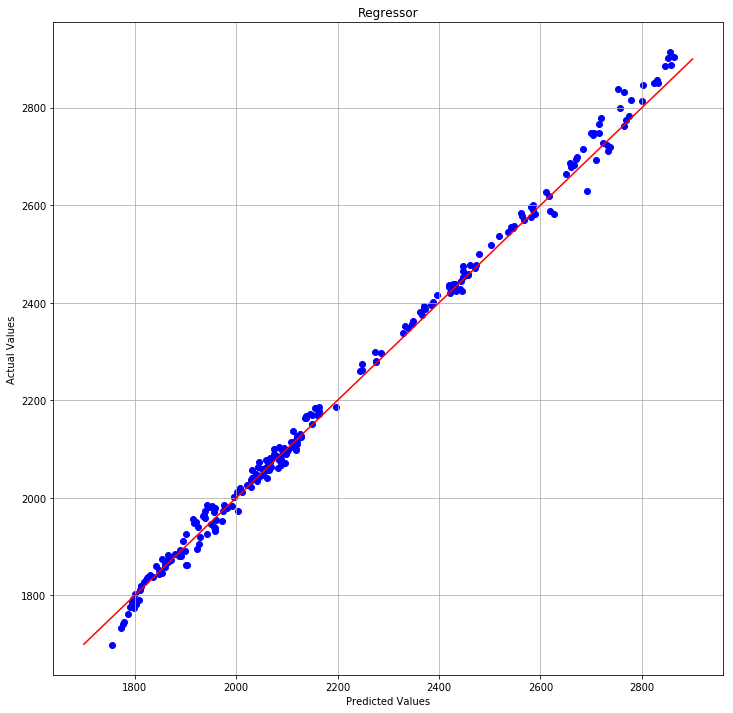

In [24]:
plot_test_ds(model, testX, testY, denormalizer, points=400)
plot_linear_func(1, 0, 1700,2900, 'r')

### 1.8- The model performed worst in the range: 2600 < SP500 < 2800. This could be due to the way the data is scattered at this point as there could be little change in the inputs at these values compared to highly varying output. This could also be due to the fact that there are less input points in higher values, thus, worse training.

# Task 2

### 2.1 Scoring Metric (default as before; Sqaure Error)
#### Given the nature of the dataset (no outliers), this is adequate

In [25]:
#gets the column with the highest correlation (APH)
# print(most_correlated_column_tag)
most_correlated_column_tag = get_most_correlated(filtered_data_set, "SP500")
most_correlated_column = filtered_data_set[[most_correlated_column_tag]]
mcc = most_correlated_column

# Remove last 5 entries due to incomplete data
most_correlated_ds = pd.concat([mcc, mcc.shift(-1), mcc.shift(-2), mcc.shift(-3), mcc.shift(-4), mcc.shift(-5)], 
                               axis=1)[:-5]
mcc_train_ds, mcc_test_ds = train_test_split(most_correlated_ds, train_size=0.8)

mcc_trainX, mcc_trainY = np.array(mcc_train_ds.iloc[:,:-1]), np.array(mcc_train_ds.iloc[:,-1:]).ravel()
mcc_testX, mcc_testY = np.array(mcc_test_ds.iloc[:,:-1]), np.array(mcc_test_ds.iloc[:,-1:]).ravel()

/home/carol/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [26]:
mcc_model_best_params = GridSearchCV(gen_model_regressor(), {
    "hidden_layer_sizes":[(100,), (5,3,2), (4,3,2)],
    "learning_rate_init":[0.1, 0.01, 0.001],
    "solver":["adam", "sgd"],
    "early_stopping":[False, True],
    "activation":['logistic'],
    "alpha":[0.001, 0.0001, 0.00001],
    "max_iter":[1000]
})
mcc_model_best_params.fit(mcc_trainX, mcc_trainY)

GridSearchCV(cv=None, error_score='raise',
       estimator=MLPRegressor(activation='logistic', alpha=0.0001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.01, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='sgd', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'hidden_layer_sizes': [(100,), (5, 3, 2), (4, 3, 2)], 'learning_rate_init': [0.1, 0.01, 0.001], 'solver': ['adam', 'sgd'], 'early_stopping': [False, True], 'activation': ['logistic'], 'alpha': [0.001, 0.0001, 1e-05], 'max_iter': [1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [27]:
mcc_model_best_params.best_params_

{'activation': 'logistic',
 'alpha': 0.0001,
 'early_stopping': False,
 'hidden_layer_sizes': (100,),
 'learning_rate_init': 0.001,
 'max_iter': 1000,
 'solver': 'adam'}

In [28]:
mcc_model = gen_model_regressor(activation_function="logistic", alpha=0.0001, early_stopping=False, 
                                learning_rate_val=0.001, iterations=1000, optimizer="adam")

In [29]:
mcc_model.fit(mcc_trainX, mcc_trainY)

MLPRegressor(activation='logistic', alpha=0.0001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=1000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

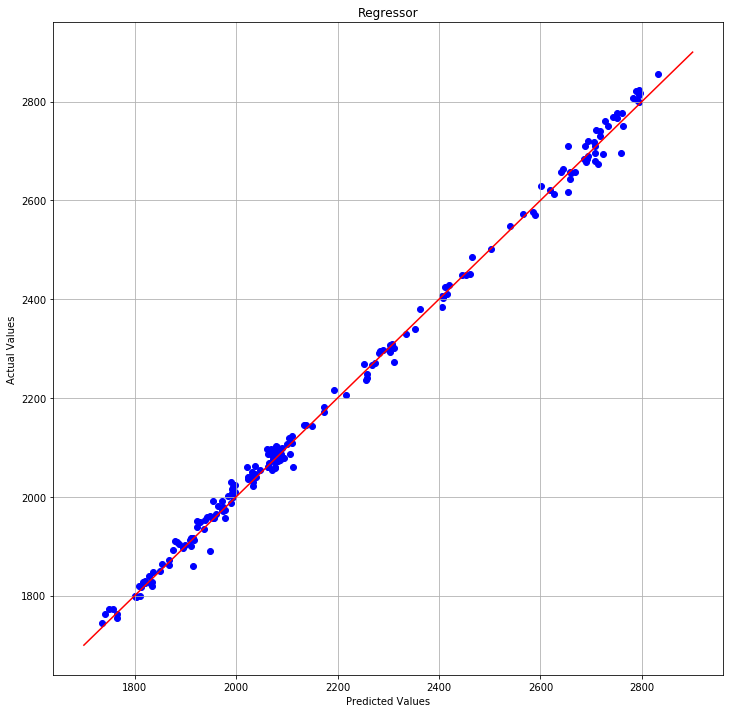

In [30]:
#2.3 We both plotted the entire test set, and printed out the first three points
#the red line is for better visual comparison
plot_test_ds(mcc_model, mcc_testX, mcc_testY, denormalizer, points=200)
plot_linear_func(1, 0, 1700,2900, 'r')


In [31]:
predicted = [denormalizer(x) for x in mcc_model.predict(mcc_testX[0:3])]
actual = [denormalizer(x) for x in mcc_testY[0:3]]
print("predicted: %s" %predicted)
print("actual   : %s" %actual)

predicted: [2109.5778621628374, 2100.5042546472096, 2415.884037270624]
actual   : [2123.91307323363, 2107.7084847407978, 2410.798117153996]


### 2.3 This Regressor produces almost-equal values, which is visually obvious in the plot, and in the printed comparison above.

# Task 3

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8adc23d128>]],
      dtype=object)

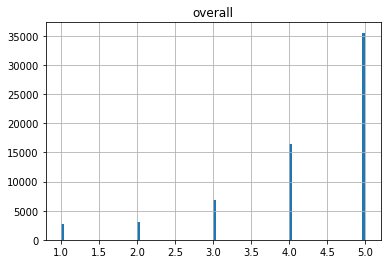

In [32]:
reviews_ds = pd.read_json("./Digital_Music_5.json", lines=True)
reviews_ds.hist('overall', bins=100) #to inspect the unbalanced DS: 3.1

In [33]:
# 3.2: sort the rows(axis=0) by their 'overall values'
# groupby creates 5 groups for each of the 'overall' values/categories, and head() is mapped to each group,
# returning the first 2500 values of each, then sample shuffles the data 
balanced_review_ds = reviews_ds.sort_values(by='overall',axis=0).groupby(['overall']).head(2500).sample(frac=1)

# 3.4
reviews_train, reviews_test = train_test_val_split(balanced_review_ds, train_size=0.8)

# We assumed "reviewText" is the desired input. Alternatively, "summary" could be taken as the textual input
# to be vectroized
reviews_trainX = reviews_train['reviewText']
reviews_trainY = reviews_train['overall']

reviews_testX = reviews_test['reviewText']
reviews_testY = reviews_test['overall']

# stop-word param is a minor optimization for the vectorizer, that excludes "english" stop words from features
# analyzer="word" does not vectorize characters to be features
# Vectorizer extracts words as features, adopting the passed params
tfidf_vectorizer = TfidfVectorizer(max_features=40000, stop_words="english", analyzer="word")

reviews_trainX = tfidf_vectorizer.fit_transform(reviews_trainX)
reviews_testX = tfidf_vectorizer.transform(reviews_testX)


/home/carol/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [34]:
classifier_model = gen_model_classifier() 

In [35]:
# takes the model and training set (input & output), from which it splits a validation set, 
# and prints the validation scores.
classifier_model_scores = cross_val_score(classifier_model, reviews_trainX, reviews_trainY, scoring='accuracy',cv=3)
print(classifier_model_scores)

[0.19970015 0.20012001 0.19867947]


In [ ]:
# #Uncomment this cell and its successor, upon desire (takes an average of 6 hours to run)
# classifier_model_best_params = GridSearchCV(classifier_model, {
#     "learning_rate_init":[0.1, 0.01, 0.001],
#     "solver":["adam"],
#     "hidden_layer_sizes": [(512), (1024), (128, 128), (128,128,128)],
#     "early_stopping":[True],
#     "activation":['logistic', 'relu'],
#     "alpha":[0.0001, 0.00001],
#     "max_iter":[500]
# })
# classifier_model_best_params.fit(reviews_trainX, reviews_trainY)

In [ ]:
# classifier_model_best_params.best_params_

In [36]:
classifier_model = gen_model_classifier(shape=(128, 128), 
                                 activation_function="relu",
                                 optimizer="adam",
                                 alpha=0.01,
                                 iterations=1000,
                                 early_stopping=True,
                                 learning_rate_val=0.0001,
                                 learning_rate_type="adaptive",
                                 verbose=True,
                                )
classifier_model.fit(reviews_trainX, reviews_trainY)

Iteration 1, loss = 1.61784511
Validation score: 0.193000
Iteration 2, loss = 1.59926408
Validation score: 0.193000
Iteration 3, loss = 1.57025139
Validation score: 0.271000
Iteration 4, loss = 1.52538810
Validation score: 0.479000
Iteration 5, loss = 1.46289853
Validation score: 0.508000
Iteration 6, loss = 1.38275198
Validation score: 0.527000
Iteration 7, loss = 1.28950507
Validation score: 0.534000
Iteration 8, loss = 1.18687485
Validation score: 0.545000
Iteration 9, loss = 1.08034236
Validation score: 0.557000
Iteration 10, loss = 0.97543623
Validation score: 0.569000
Iteration 11, loss = 0.87354647
Validation score: 0.574000
Iteration 12, loss = 0.77891517
Validation score: 0.589000
Iteration 13, loss = 0.69323764
Validation score: 0.596000
Iteration 14, loss = 0.61459716
Validation score: 0.603000
Iteration 15, loss = 0.54422674
Validation score: 0.594000
Iteration 16, loss = 0.48099132
Validation score: 0.599000
Iteration 17, loss = 0.42479763
Validation score: 0.600000
Valida

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=True, epsilon=1e-08,
       hidden_layer_sizes=(128, 128), learning_rate='adaptive',
       learning_rate_init=0.0001, max_iter=1000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=True, warm_start=False)

In [37]:
classifier_model.score(reviews_testX, reviews_testY)

0.5872

Normalized confusion matrix
[[0.69444444 0.19444444 0.03571429 0.04166667 0.03373016]
 [0.22908367 0.43027888 0.16733068 0.09760956 0.07569721]
 [0.04280156 0.18287938 0.49416342 0.19844358 0.08171206]
 [0.05394191 0.07261411 0.22821577 0.54771784 0.09751037]
 [0.03413655 0.03815261 0.11646586 0.04016064 0.77108434]]


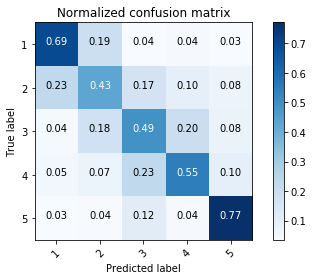

In [38]:
# Compute confusion matrix
reviews_predY = classifier_model.predict(reviews_testX)
cnf_matrix = confusion_matrix(reviews_testY, reviews_predY)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['1', '2', '3', '4', '5'], normalize=True, 
                      title='Normalized confusion matrix')
plt.show()

In [39]:
print("output activation function: %s" %classifier_model.out_activation_)

output activation function: softmax


### 3.8  Output Activation Function: softmax. We only have control over the activation function of the hidden layers. SKLearn uses this particular fn. for the output nodes because it's a classifier.

# BONUS

In [40]:
#1
predicted = classifier_model.predict(reviews_testX[0:10])
actual = np.array(reviews_testY[0:10])
print("predicted: %s" %predicted)
print("actual   : %s" %actual)

predicted: [4 3 2 2 4 5 1 3 1 4]
actual   : [4 3 2 2 4 5 2 2 1 4]


### 2 The are too many features, each of which has very low correlation. Following the Curse of Dimensionality definiton, as the number of features grows, the number of data points needed to generalize accurately grows *exponentially*. The size of input examples used for training was 10k, when in the best case (bonus), the size of input features was 25k, when using the reviewText column.  

### 3-4: The dataset is modified by adding an additional column which depends on the helpful ratings, and is included in training
### Additionally, we use an NLP stemmer in the vectorizer to reduce the number of tokens/features; treat a word and its stemmings as one. 


In [41]:
# copies the original dataset (unbalanced)
reviews_ds_2 = reviews_ds.copy()

# the "helpful" column of the dataset, has pairs of two integers; counts of positive/negative votes
# that correspond to whether or not this review was helpful to other users

# adds a column "positive" to it, which takes the log of the first element +1 of each pair in the "helpful" column
reviews_ds_2["positive"] = reviews_ds_2["helpful"].map(
    lambda helpful_ary: math.log(helpful_ary[0] + 1))

# adds a column "negative" to it, which takes the log of the second element +1 of each pair in the "helpful" column
reviews_ds_2["negative"] = reviews_ds_2["helpful"].map(
    lambda helpful_ary: math.log(helpful_ary[1] + 1))

# adds a column RS to it, which gets the absolute difference b/w the counts of helpful/not-helpful votes,
# then takes the log of this value +1
reviews_ds_2["ratingScore"] = reviews_ds_2["helpful"].map(
    lambda helpful_ary: math.log(math.fabs(helpful_ary[0] - helpful_ary[1]) + 1))

rs = reviews_ds_2["ratingScore"]
reviews_ds_2["ratingScore"] = (rs - rs.mean()) / rs.std()

#positive score, normalized
ps = reviews_ds_2["positive"]
reviews_ds_2["positive"] = (ps - ps.mean()) / ps.std()

#negative score, normalized
ns = reviews_ds_2["negative"]
reviews_ds_2["negative"] = (ns - ns.mean()) / ns.std()

reviews_ds_2.corr()

,overall,unixReviewTime,positive,negative,ratingScore
overall,1.000000,0.036989,-0.053896,-0.247346,-0.475316
unixReviewTime,0.036989,1.000000,-0.258202,-0.281726,-0.146229
positive,-0.053896,-0.258202,1.000000,0.903549,0.403731
negative,-0.247346,-0.281726,0.903549,1.000000,0.719568
ratingScore,-0.475316,-0.146229,0.403731,0.719568,1.000000


In [42]:
# balance the new dataset
balanced_reviews_ds_2 = reviews_ds_2.sort_values(by='overall',axis=0).groupby(['overall']).head(2500).sample(frac=1)
# split into train and test sets
reviews_train_2, reviews_test_2 = train_test_val_split(balanced_reviews_ds_2, train_size=0.8)
# resets the index after splitting 
reviews_train_2 = reviews_train_2.reset_index(drop=True)
reviews_test_2 = reviews_test_2.reset_index(drop=True)
# set the outputs 
reviews_trainY_2 = reviews_train_2['overall']
reviews_testY_2 = reviews_test_2['overall']
# the tokenizer param uses one from nltk lib that stems the words (reduces the number of extracted features)
# the choice of forcefully decreasing the number of max allowed features was based on trial and error to get
# an optimum value
tfidf_vectorizer_reviewText = TfidfVectorizer(max_features=25000, stop_words="english", 
                                     analyzer="word", tokenizer=stemming_tokenizer)
tfidf_vectorizer_summary = TfidfVectorizer(max_features=7500, stop_words="english", 
                                       analyzer="word", tokenizer=stemming_tokenizer)

# use "reviewText" as input text to the vectorizer, fit_and_transform the training set
tfidf_vectorizer_reviewText.fit(reviews_train_2['reviewText'])
reviews_train_reviewText = tfidf_vectorizer_reviewText.transform(reviews_train_2['reviewText'])

# use "summary" as input text to the vectorizer, fit_and_transform the training set
tfidf_vectorizer_summary.fit(reviews_train_2['summary'])
reviews_train_summary = tfidf_vectorizer_summary.transform(reviews_train_2['summary'])

# only transform the test set
reviews_test_reviewText = tfidf_vectorizer_reviewText.transform(reviews_test_2['reviewText'])
reviews_test_summary = tfidf_vectorizer_summary.transform(reviews_test_2['summary'])

# reshapes the values within the vector cells to be an array of integers, instead
# of integers
train_size=10000
positive_ratings_train = reviews_train_2['positive'].values.reshape(train_size,1)
negative_ratings_train = reviews_train_2['negative'].values.reshape(train_size,1)
ratings_score_train = reviews_train_2['ratingScore'].values.reshape(train_size,1)

test_size=2500
positive_ratings_test = reviews_test_2['positive'].values.reshape(test_size,1)
negative_ratings_test = reviews_test_2['negative'].values.reshape(test_size,1)
ratings_score_test = reviews_test_2['ratingScore'].values.reshape(test_size, 1)

# concatenates
reviews_trainX_2 = hstack([reviews_train_reviewText, reviews_train_summary, ratings_score_train])
reviews_testX_2 = hstack([reviews_test_reviewText, reviews_test_summary, ratings_score_test])

/home/carol/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [45]:
print(reviews_train_summary.shape)
print(reviews_train_reviewText.shape)
print(reviews_trainX_2.shape)
print(reviews_testX_2.shape)

(10000, 5780)
(10000, 25000)
(10000, 30781)
(2500, 30781)


In [46]:
classifier_model2 = gen_model_classifier(shape=(128, 128),
                                 activation_function="relu",
                                 optimizer="adam",
                                 alpha=0.01,
                                 iterations=500,
                                 early_stopping=True,
                                 learning_rate_val=0.0005,
                                 learning_rate_type="adaptive",
                                 verbose=True,
                                )

classifier_model2.fit(reviews_trainX_2, reviews_trainY_2)

Iteration 1, loss = 1.52550900
Validation score: 0.460000
Iteration 2, loss = 1.19332231
Validation score: 0.605000
Iteration 3, loss = 0.79879562
Validation score: 0.641000
Iteration 4, loss = 0.47257114
Validation score: 0.641000
Iteration 5, loss = 0.26591952
Validation score: 0.649000
Iteration 6, loss = 0.15190458
Validation score: 0.638000
Iteration 7, loss = 0.08946642
Validation score: 0.635000
Iteration 8, loss = 0.05586289
Validation score: 0.642000
Validation score did not improve more than tol=0.000100 for two consecutive epochs. Stopping.


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=True, epsilon=1e-08,
       hidden_layer_sizes=(128, 128), learning_rate='adaptive',
       learning_rate_init=0.0005, max_iter=500, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=True, warm_start=False)

In [47]:
classifier_model2.score(reviews_testX_2, reviews_testY_2)

0.638

Normalized confusion matrix
[[0.696      0.24       0.04       0.01       0.014     ]
 [0.19361277 0.54690619 0.18562874 0.03792415 0.03592814]
 [0.05314961 0.18307087 0.5511811  0.1476378  0.06496063]
 [0.01960784 0.05686275 0.18235294 0.60392157 0.1372549 ]
 [0.02286902 0.03118503 0.05405405 0.09147609 0.8004158 ]]


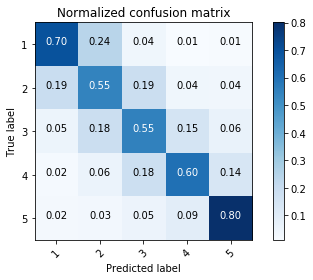

In [48]:
# Compute confusion matrix
reviews_predY_2 = classifier_model2.predict(reviews_testX_2)
cnf_matrix_2 = confusion_matrix(reviews_testY_2, reviews_predY_2)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_2, classes=['1', '2', '3', '4', '5'], normalize=True, 
                      title='Normalized confusion matrix')
plt.show()
